In [17]:
import pandas as pd
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings("ignore")
import statsmodels
import stargazer
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
colors= {
    'All':'grey',
    'male': '#009E73',
    'female': '#E69F00'
}

fields = ['Art','Biology', 'Business','Chemistry',\
          'Computer Science','Economics','Engineering'\
          ,'Environmental Science','Geography','Geology',\
         'History','Materials Science','Mathematics',\
          'Philosophy','Physics','Political Science','Psychology','Sociology']

ordered_plots = [
 'All', 'Mathematics','Physics','Materials Science',
 'Geology','Engineering','Computer Science', 'Economics','Environmental Science',
 'Chemistry', 'History', 'Geography', 'Philosophy', 'Biology', 'Business',
 'Art', 'Political Science', 'Sociology', 'Psychology']


In [18]:
# p-value threshold to consider signifficant or not
pv_limit = 0.01

In [19]:
compare_value = pd.read_csv("paper/summary_models_all_gender_signal.csv")
compare_value['Productivity_perc'] = compare_value['Productivity_coef'].apply(lambda x: (np.exp(x) -1) * 100 )
compare_value['Collaborations_perc'] = compare_value['Collaborations_coef'].apply(lambda x: (np.exp(x) -1) * 100 )
compare_value['Gender_perc'] = compare_value['Gender_coef'].apply(lambda x: (np.exp(x) -1) * 100 )
compare_value['ordered'] = compare_value['Field'].apply(lambda x: ordered_plots.index(x))
compare_value.rename(columns= {'Data':'Top Size'}, inplace=True)
compare_value.head()

,Top Size,Field,Model,McFadden R²,N,Productivity_coef,Collaborations_coef,Prod_x_Collab_coef,Gender_coef,Career3_Medium_11_25_coef,...,Gender_pvalue,Career3_Medium_11_25_pvalue,Career3_Senior_26_plus_pvalue,Scope,MatchingType,Ranking,Productivity_perc,Collaborations_perc,Gender_perc,ordered
0,matching_overall_5pc,All,FE Field+Year,0.091345,1518974,0.018923,0.000274,-0.000002,0.081692,0.898471,...,1.057248e-73,1.223771e-42,5.425798e-57,All fields,Overall,5%,1.910361,0.027369,8.512156,0
1,matching_women_5pc,All,FE Field+Year,0.081089,2211442,0.038755,0.000477,-0.000004,0.036454,0.729839,...,1.728878e-170,2.334577e-199,1.924714e-85,All fields,Women→Men,5%,3.951564,0.047747,3.712622,0
2,matching_men_5pc,All,FE Field+Year,0.089884,7057222,0.033266,0.000451,-0.000004,0.345501,0.724516,...,3.350061e-17,0.000000e+00,0.000000e+00,All fields,Men→Women,5%,3.382562,0.045149,41.269695,0
3,matching_overall_10pc,All,FE Field+Year,0.090699,2962099,0.024398,0.000315,-0.000002,0.080440,0.819026,...,3.050124e-104,2.817238e-39,1.628838e-58,All fields,Overall,10%,2.469803,0.031509,8.376378,0
4,matching_women_10pc,All,FE Field+Year,0.078816,3975428,0.047513,0.000501,-0.000005,0.023231,0.683804,...,1.647348e-17,9.790080e-254,6.669381e-104,All fields,Women→Men,10%,4.865981,0.050141,2.350295,0



Processing matching_overall_10pc researchers...
Final dataset has 19 rows covering 19 unique fields

Processing matching_women_10pc researchers...
Final dataset has 19 rows covering 19 unique fields

Processing matching_men_10pc researchers...
Final dataset has 19 rows covering 19 unique fields


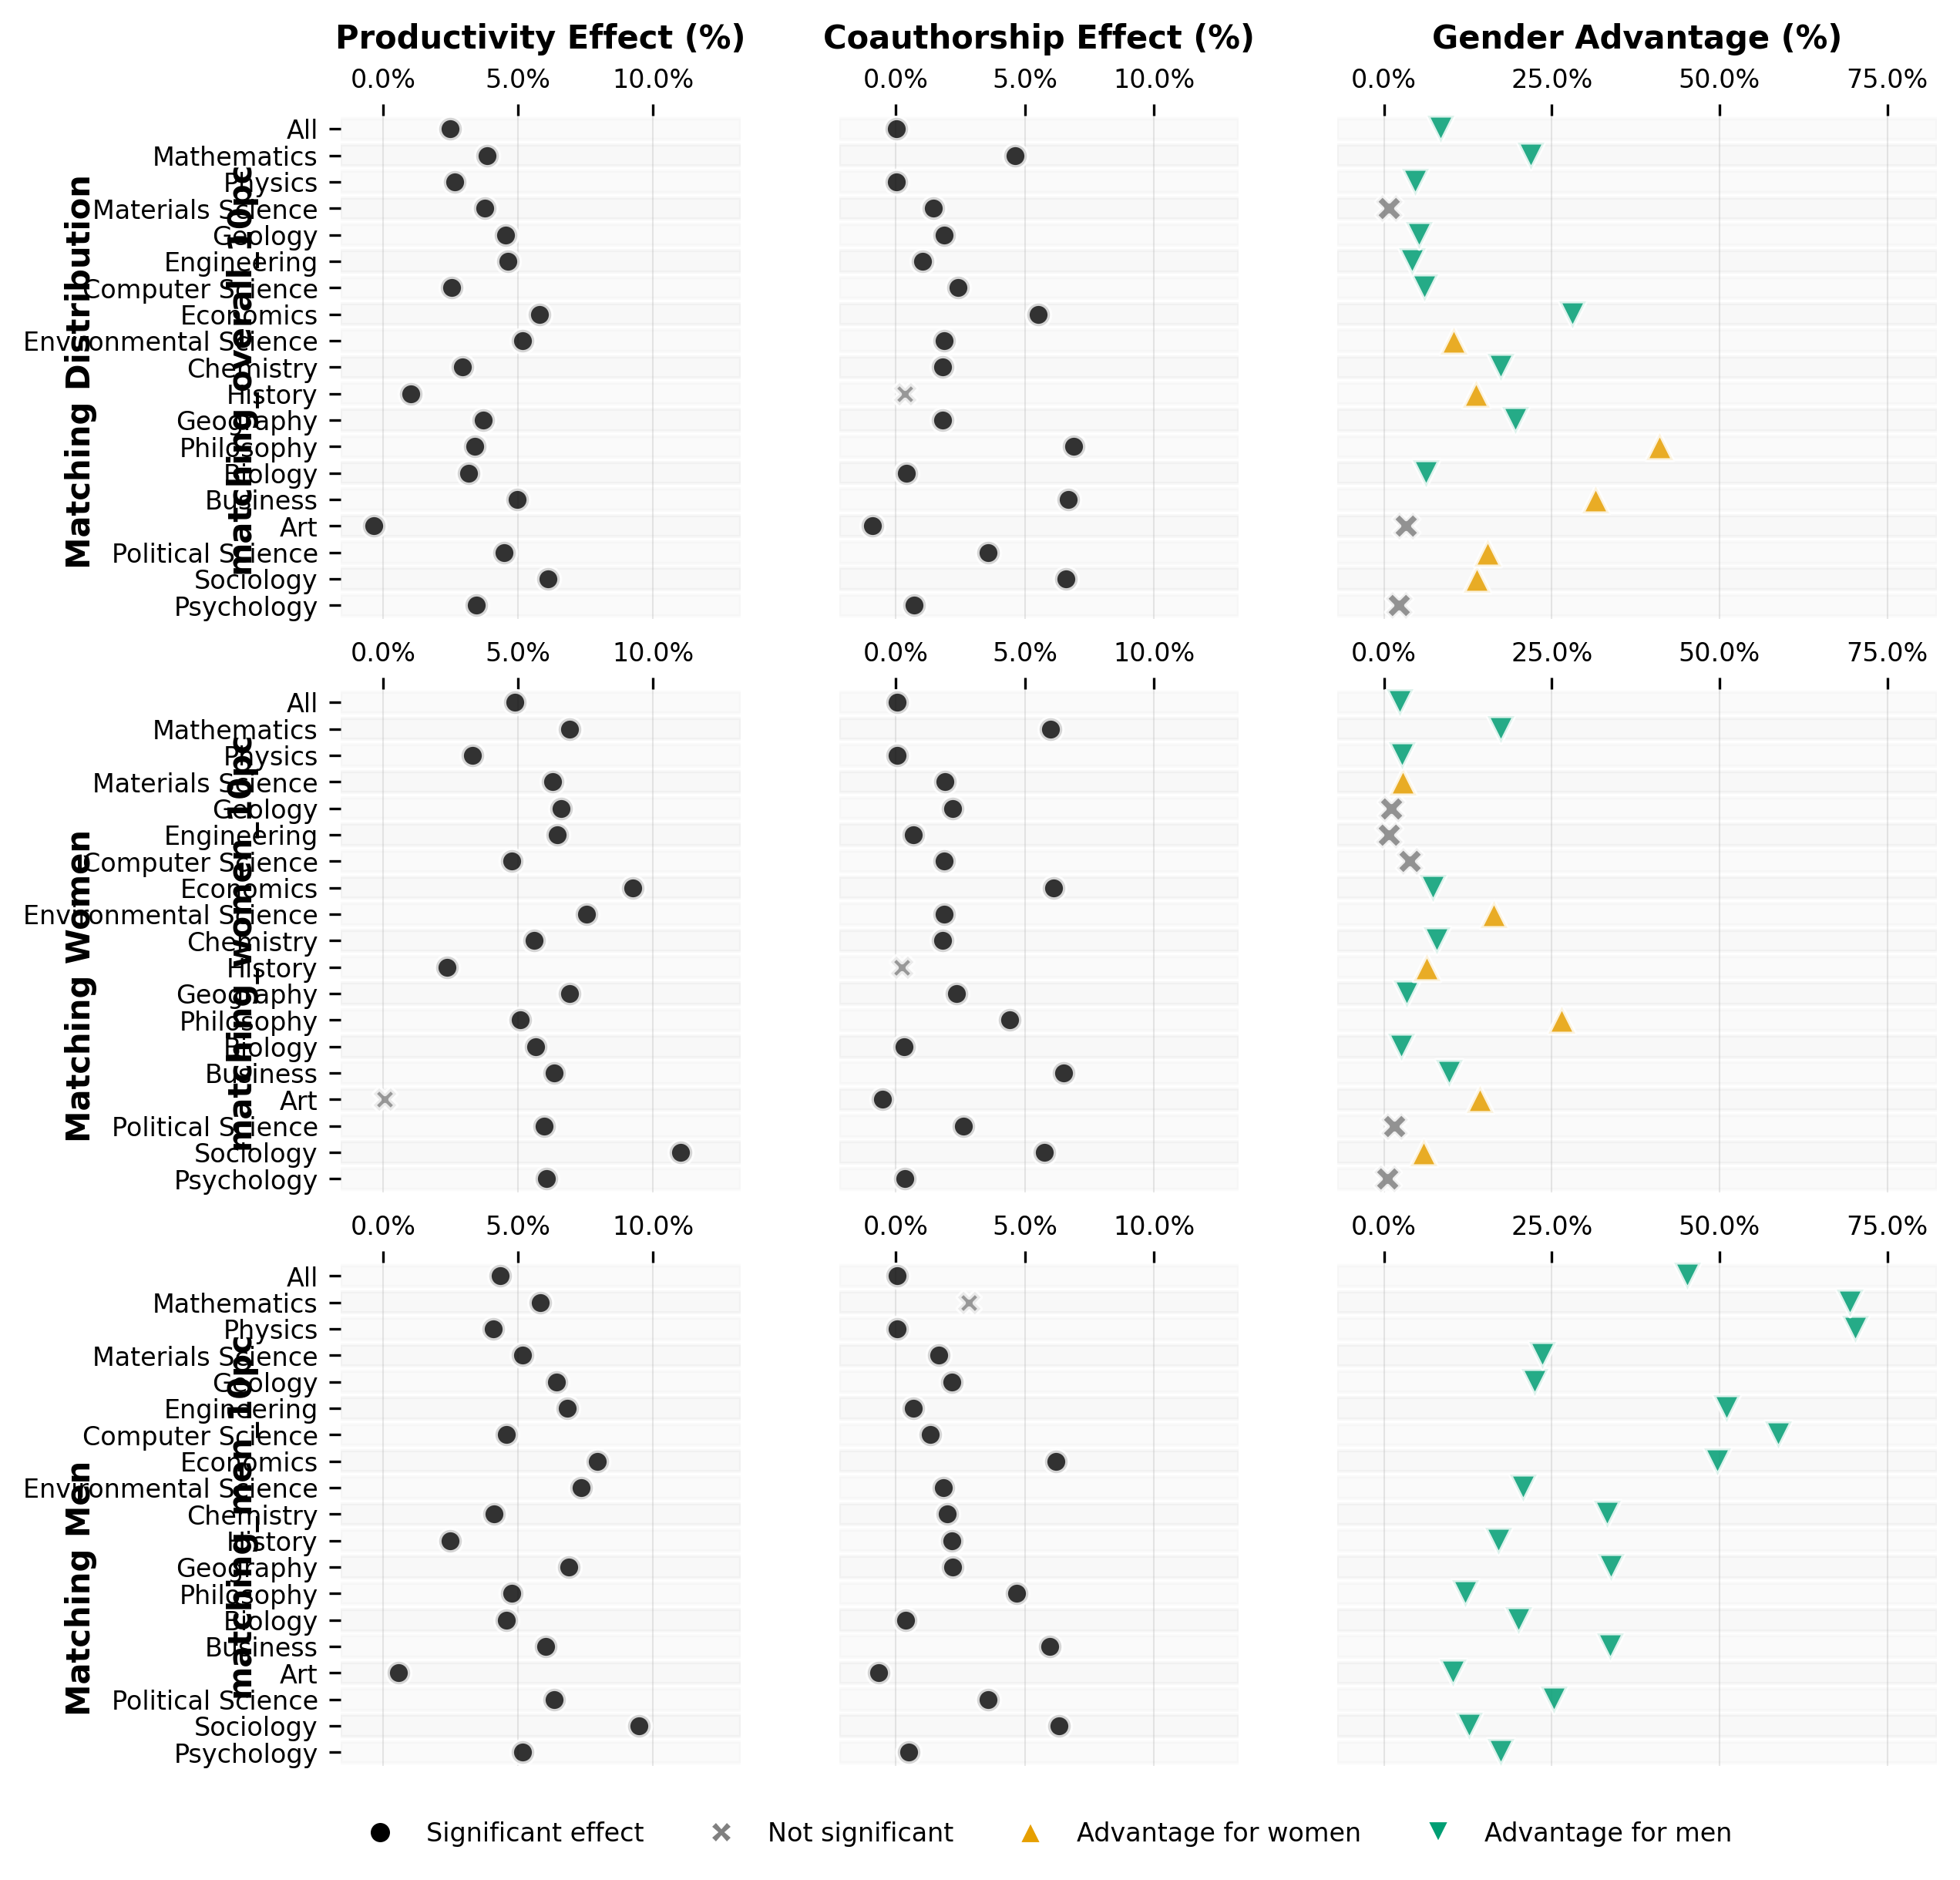

Completed analysis with 3 rows for different researcher types


In [20]:
# Set up plotting parameters
plt.rcParams['text.usetex'] = False  # Set to True if you have LaTeX installed
plt.rcParams['font.size'] = 9

# Define colors matching your original style
colors = {
    'All': 'grey',
    'male': '#009E73',
    'female': '#E69F00'
}

# Variables that we want to include in the figure
key_metrics = ['Productivity', 'Collaborations', 'Gender']

markers = {"female": "P", "male": "X"}

# Parameters 
modeltype = 'NegBinomial(citations)'
firstyear = 1990
lastyear = 2020

# Create figure with R rows and C columns 
fig = plt.figure(figsize=(8, 9), dpi=300)
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1.5])  # Last column wider for gender coefficients
ax = []
for row in range(3):
    ax_row = []
    for col in range(3):
        ax_row.append(fig.add_subplot(gs[row, col]))
    ax.append(ax_row)

# Use this variable to feed the figure
all_plot_data = []

# ranking_ = '5%'
# ts_values = ['matching_overall_5pc', 'matching_women_5pc', 'matching_men_5pc'] 

ranking_ = '10%'
ts_values = ['matching_overall_10pc', 'matching_women_10pc', 'matching_men_10pc'] 

# Markers to use
field_markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']

for ts in ts_values:
    
    print(f"\nProcessing {ts} researchers...")
    
    # Get sample
    filtered_data = compare_value[(compare_value['Ranking'] == ranking_) & (compare_value['Top Size'] == ts)]
    
    # Remove any matching style duplicates
    filtered_data = filtered_data.drop_duplicates(subset=['Field'])
    
    print(f"Final dataset has {len(filtered_data)} rows covering {len(filtered_data['Field'].unique())} unique fields")

    # Add ordering for consistent field display
    compare_value['ordered'] = compare_value['Field'].apply(lambda x: ordered_plots.index(x) if x in ordered_plots else 999)

    # Sort data by field order and add ts identifier
    plot_data = filtered_data.sort_values(by=['ordered'], ascending=False).copy()
    plot_data['ts_group'] = ts  # Add identifier for this ts group
    all_plot_data.append(plot_data)

# Combine all data
combined_plot_data = pd.concat(all_plot_data, ignore_index=True)

# Get unique fields in the correct order for shading (from combined data)
unique_fields = combined_plot_data['Field'].unique()
field_to_position = {field: i for i, field in enumerate(unique_fields)}

# Convert field names to numeric positions for consistent ordering
combined_plot_data['field_position'] = combined_plot_data['Field'].map(field_to_position)

# Add alternating background shading across all panels
for row in range(3):
    for col in range(3):
        for j, field in enumerate(unique_fields):
            if j % 2 == 0:  # Every other field gets light gray shading
                ax[row][col].axhspan(j - 0.4, j + 0.4, alpha=0.1, color='lightgray', zorder=0)
            else:  # Other fields get darker gray shading
                ax[row][col].axhspan(j - 0.4, j + 0.4, alpha=0.05, color='gray', zorder=0)


# Define categories
markers_config = {
    'significant': 'o',      # Circle for significant effects
    'not_significant': 'X',  # X for not significant
    'female_advantage': '^', # Triangle up for female advantage  
    'male_advantage': 'v'    # Triangle down for male advantage
}

# Now plot each ts_value as a separate row
for row_idx, ts in enumerate(ts_values):
    ts_data = combined_plot_data[combined_plot_data['ts_group'] == ts]
    
    # COLUMN 1: Productivity effects
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[0]}_coef'], ts_data[f'{key_metrics[0]}_pvalue'], ts_data['field_position']):
        # Choose marker and color based on significance
        if pv < pv_limit:
            marker = markers_config['significant']
            color = "black"
        else:
            marker = markers_config['not_significant'] 
            color = "grey"
        
        # Convert to percentage effects
        prod_effect = (np.exp(coeff) - 1) * 100
        
        ax[row_idx][0].scatter(prod_effect, field_pos, 
                              c=color, s=50, marker=marker, edgecolor='white', linewidth=1.5, alpha=0.8)

    ax[row_idx][0].set_xlabel("", fontsize=9)
    if row_idx == 0:  # Only show field labels on the first row
        ax[row_idx][0].set_yticks(range(len(unique_fields)))
        ax[row_idx][0].set_yticklabels(unique_fields)
    else:
        ax[row_idx][0].set_ylabel("")
        # ax[row_idx][0].set_yticks([])

    # COLUMN 2: Collaborations effects
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[1]}_coef'], ts_data[f'{key_metrics[1]}_pvalue'], ts_data['field_position']):
        # Choose marker and color based on significance
        if pv < pv_limit:
            marker = markers_config['significant']
            color = "black"
        else:
            marker = markers_config['not_significant']
            color = "grey"
        
        # Convert to percentage effects
        collab_effect = (np.exp(coeff) - 1) * 100
        
        ax[row_idx][1].scatter(collab_effect, field_pos, 
                              c=color, s=50, marker=marker, edgecolor='white', linewidth=1.5, alpha=0.8)

    ax[row_idx][1].set_xlabel("", fontsize=9)
    ax[row_idx][1].set_yticks([])

    # COLUMN 3: Gender coefficients (always positive values)
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[2]}_coef'], ts_data[f'{key_metrics[2]}_pvalue'], ts_data['field_position']):
        exp_coeff = np.exp(coeff)
        
        # Calculate percentage advantage (always positive) and assign marker/color
        if pv >= pv_limit:  # Not significant
            percentage = (1/exp_coeff - 1) * 100 if exp_coeff < 1 else (exp_coeff - 1) * 100
            marker = markers_config['not_significant']
            color = "grey"
        elif exp_coeff < 1:  # Female advantage (significant)
            percentage = (1/exp_coeff - 1) * 100  # Make positive
            marker = markers_config['female_advantage']
            color = colors['female']
        else:  # Male advantage (significant)
            percentage = (exp_coeff - 1) * 100    # Already positive
            marker = markers_config['male_advantage']
            color = colors['male']
        
        ax[row_idx][2].scatter(percentage, field_pos,
                              c=color, s=70, marker=marker, 
                              edgecolor='white', linewidth=1.2, alpha=0.85)

    # Add vertical reference line (removed since we don't need 0 reference for always-positive values)
    # ax[row_idx][2].axvline(0, color='lightgrey', linestyle='dotted', alpha=0.6, linewidth=1)
    ax[row_idx][2].set_xlabel("", fontsize=9)
    ax[row_idx][2].set_yticks([])

# Add row labels on the left side
row_labels = [ts_values[i] for i in range(3)]
for row_idx, label in enumerate(row_labels):
    # Add row label to the left of the first column
    ax[row_idx][0].text(-0.25, 0.5, label, transform=ax[row_idx][0].transAxes, 
                       fontsize=10, fontweight='bold', va='center', ha='center', rotation=90)

# Style all panels
for row in range(3):
    for col in range(3):
        ax[row][col].spines['right'].set_visible(False)
        ax[row][col].spines['top'].set_visible(False)
        ax[row][col].spines['bottom'].set_visible(False)
        ax[row][col].spines['left'].set_visible(False)
        
        # Move x-axis to top
        ax[row][col].xaxis.tick_top()
        ax[row][col].tick_params(labelbottom=False, labeltop=True)
        ax[row][col].xaxis.set_label_position('top')
        
        # Set y-axis to use field positions and labels
        ax[row][col].set_ylim(-0.5, len(unique_fields) - 0.5)
        if col == 0:
            ax[row][col].set_yticks(range(len(unique_fields)))
            ax[row][col].set_yticklabels(ts_data['Field'].unique())
        else:
            ax[row][col].set_yticks([])
            
        # Style ticks
        ax[row][col].tick_params(axis='x', labelsize=8)
        ax[row][col].tick_params(axis='y', labelsize=8)
        
        ax[row][col].set_ylabel("")
        
        # Add grid lines
        ax[row][col].grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
        ax[row][col].set_axisbelow(True)

# Add column headers only on the top row
column_headers = ['Productivity Effect (%)', 'Coauthorship Effect (%)', 'Gender Advantage (%)']
for col_idx, header in enumerate(column_headers):
    ax[0][col_idx].text(0.5, 1.12, header, transform=ax[0][col_idx].transAxes, 
                       fontsize=10, fontweight='bold', va='bottom', ha='center')


column_headers = ['Matching Distribution', 'Matching Women', 'Matching Men']
for row_idx, header in enumerate(column_headers):
    ax[row_idx][0].text(-0.65, 0.1, header, transform=ax[row_idx][0].transAxes,rotation=90, 
                       fontsize=10, fontweight='bold', va='bottom', ha='center')

# Calculate global ranges for consistent scaling across all rows
all_prod_effects = []
all_collab_effects = []
all_gender_percentages = []

for ts in ts_values:
    ts_data = combined_plot_data[combined_plot_data['ts_group'] == ts]
    
    # Calculate productivity effects
    if f'{key_metrics[0]}_coef' in ts_data.columns:
        prod_effects = (ts_data[f'{key_metrics[0]}_coef'].apply(lambda x: np.exp(x)) - 1) * 100
        all_prod_effects.extend(prod_effects.tolist())
    
    # Calculate collaboration effects
    if f'{key_metrics[1]}_coef' in ts_data.columns:
        collab_effects = (ts_data[f'{key_metrics[1]}_coef'].apply(lambda x: np.exp(x)) - 1) * 100
        all_collab_effects.extend(collab_effects.tolist())
    
    # Calculate gender percentages (always positive)
    if f'{key_metrics[2]}_coef' in ts_data.columns:
        for coeff in ts_data[f'{key_metrics[2]}_coef']:
            exp_coeff = np.exp(coeff)
            if exp_coeff < 1:  # Female advantage
                percentage = (1/exp_coeff - 1) * 100  # Make positive
            else:  # Male advantage  
                percentage = (exp_coeff - 1) * 100
            all_gender_percentages.append(percentage)

# Calculate global ranges with margins
prod_min, prod_max = min(all_prod_effects), max(all_prod_effects)
prod_max = 12
prod_range = prod_max - prod_min
prod_margin = prod_range * 0.1
global_prod_xlim = (prod_min - prod_margin, prod_max + prod_margin)

collab_min, collab_max = min(all_collab_effects), max(all_collab_effects)
collab_max = 12
collab_range = collab_max - collab_min
collab_margin = collab_range * 0.1
global_collab_xlim = (collab_min - collab_margin, collab_max + collab_margin)

gender_min, gender_max = min(all_gender_percentages), max(all_gender_percentages)
gender_max = 75
gender_range = gender_max - gender_min
gender_margin = gender_range * 0.1
global_gender_xlim = (gender_min - gender_margin, gender_max + gender_margin)

# Apply global ranges to all panels
for row in range(3):
    # Column 1: Productivity effects - same range for all rows
    ax[row][0].set_xlim(global_prod_xlim)
    ax[row][0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][0].locator_params(axis='x', nbins=4)
    
    # Column 2: Collaboration effects - same range for all rows
    ax[row][1].set_xlim(global_collab_xlim)
    ax[row][1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][1].locator_params(axis='x', nbins=4)
    
    # Column 3: Gender advantages - same range for all rows, always positive
    ax[row][2].set_xlim(global_gender_xlim)
    ax[row][2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][2].locator_params(axis='x', nbins=4)


# Create simplified legend with different markers
legend_elements = [
    # Significance indicators for Productivity and Collaboration columns
    plt.Line2D([0], [0], marker=markers_config['significant'], color='w', markerfacecolor='black', 
               markersize=7, linestyle='', label="Significant effect"),
    plt.Line2D([0], [0], marker=markers_config['not_significant'], color='w', markerfacecolor='grey', 
               markersize=7, linestyle='', label="Not significant"),
    
    # Gender advantage indicators (for gender column only)
    plt.Line2D([0], [0], marker=markers_config['female_advantage'], color='w', markerfacecolor=colors['female'], 
               markersize=7, linestyle='', label="Advantage for women"),
    plt.Line2D([0], [0], marker=markers_config['male_advantage'], color='w', markerfacecolor=colors['male'], 
               markersize=7, linestyle='', label="Advantage for men")
]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.10), frameon=False,
           ncol=4, fontsize=8)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, left=0.12)  # Extra space for row labels and legend

# Save the figure
plt.savefig(f"three_row_research_metrics_by_ts_10pct.svg", dpi=300, bbox_inches='tight')
plt.savefig(f"three_row_research_metrics_by_ts_10pct.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Completed analysis with {len(ts_values)} rows for different researcher types")


Processing matching_overall_5pc researchers...
Final dataset has 19 rows covering 19 unique fields

Processing matching_women_5pc researchers...
Final dataset has 19 rows covering 19 unique fields

Processing matching_men_5pc researchers...
Final dataset has 19 rows covering 19 unique fields


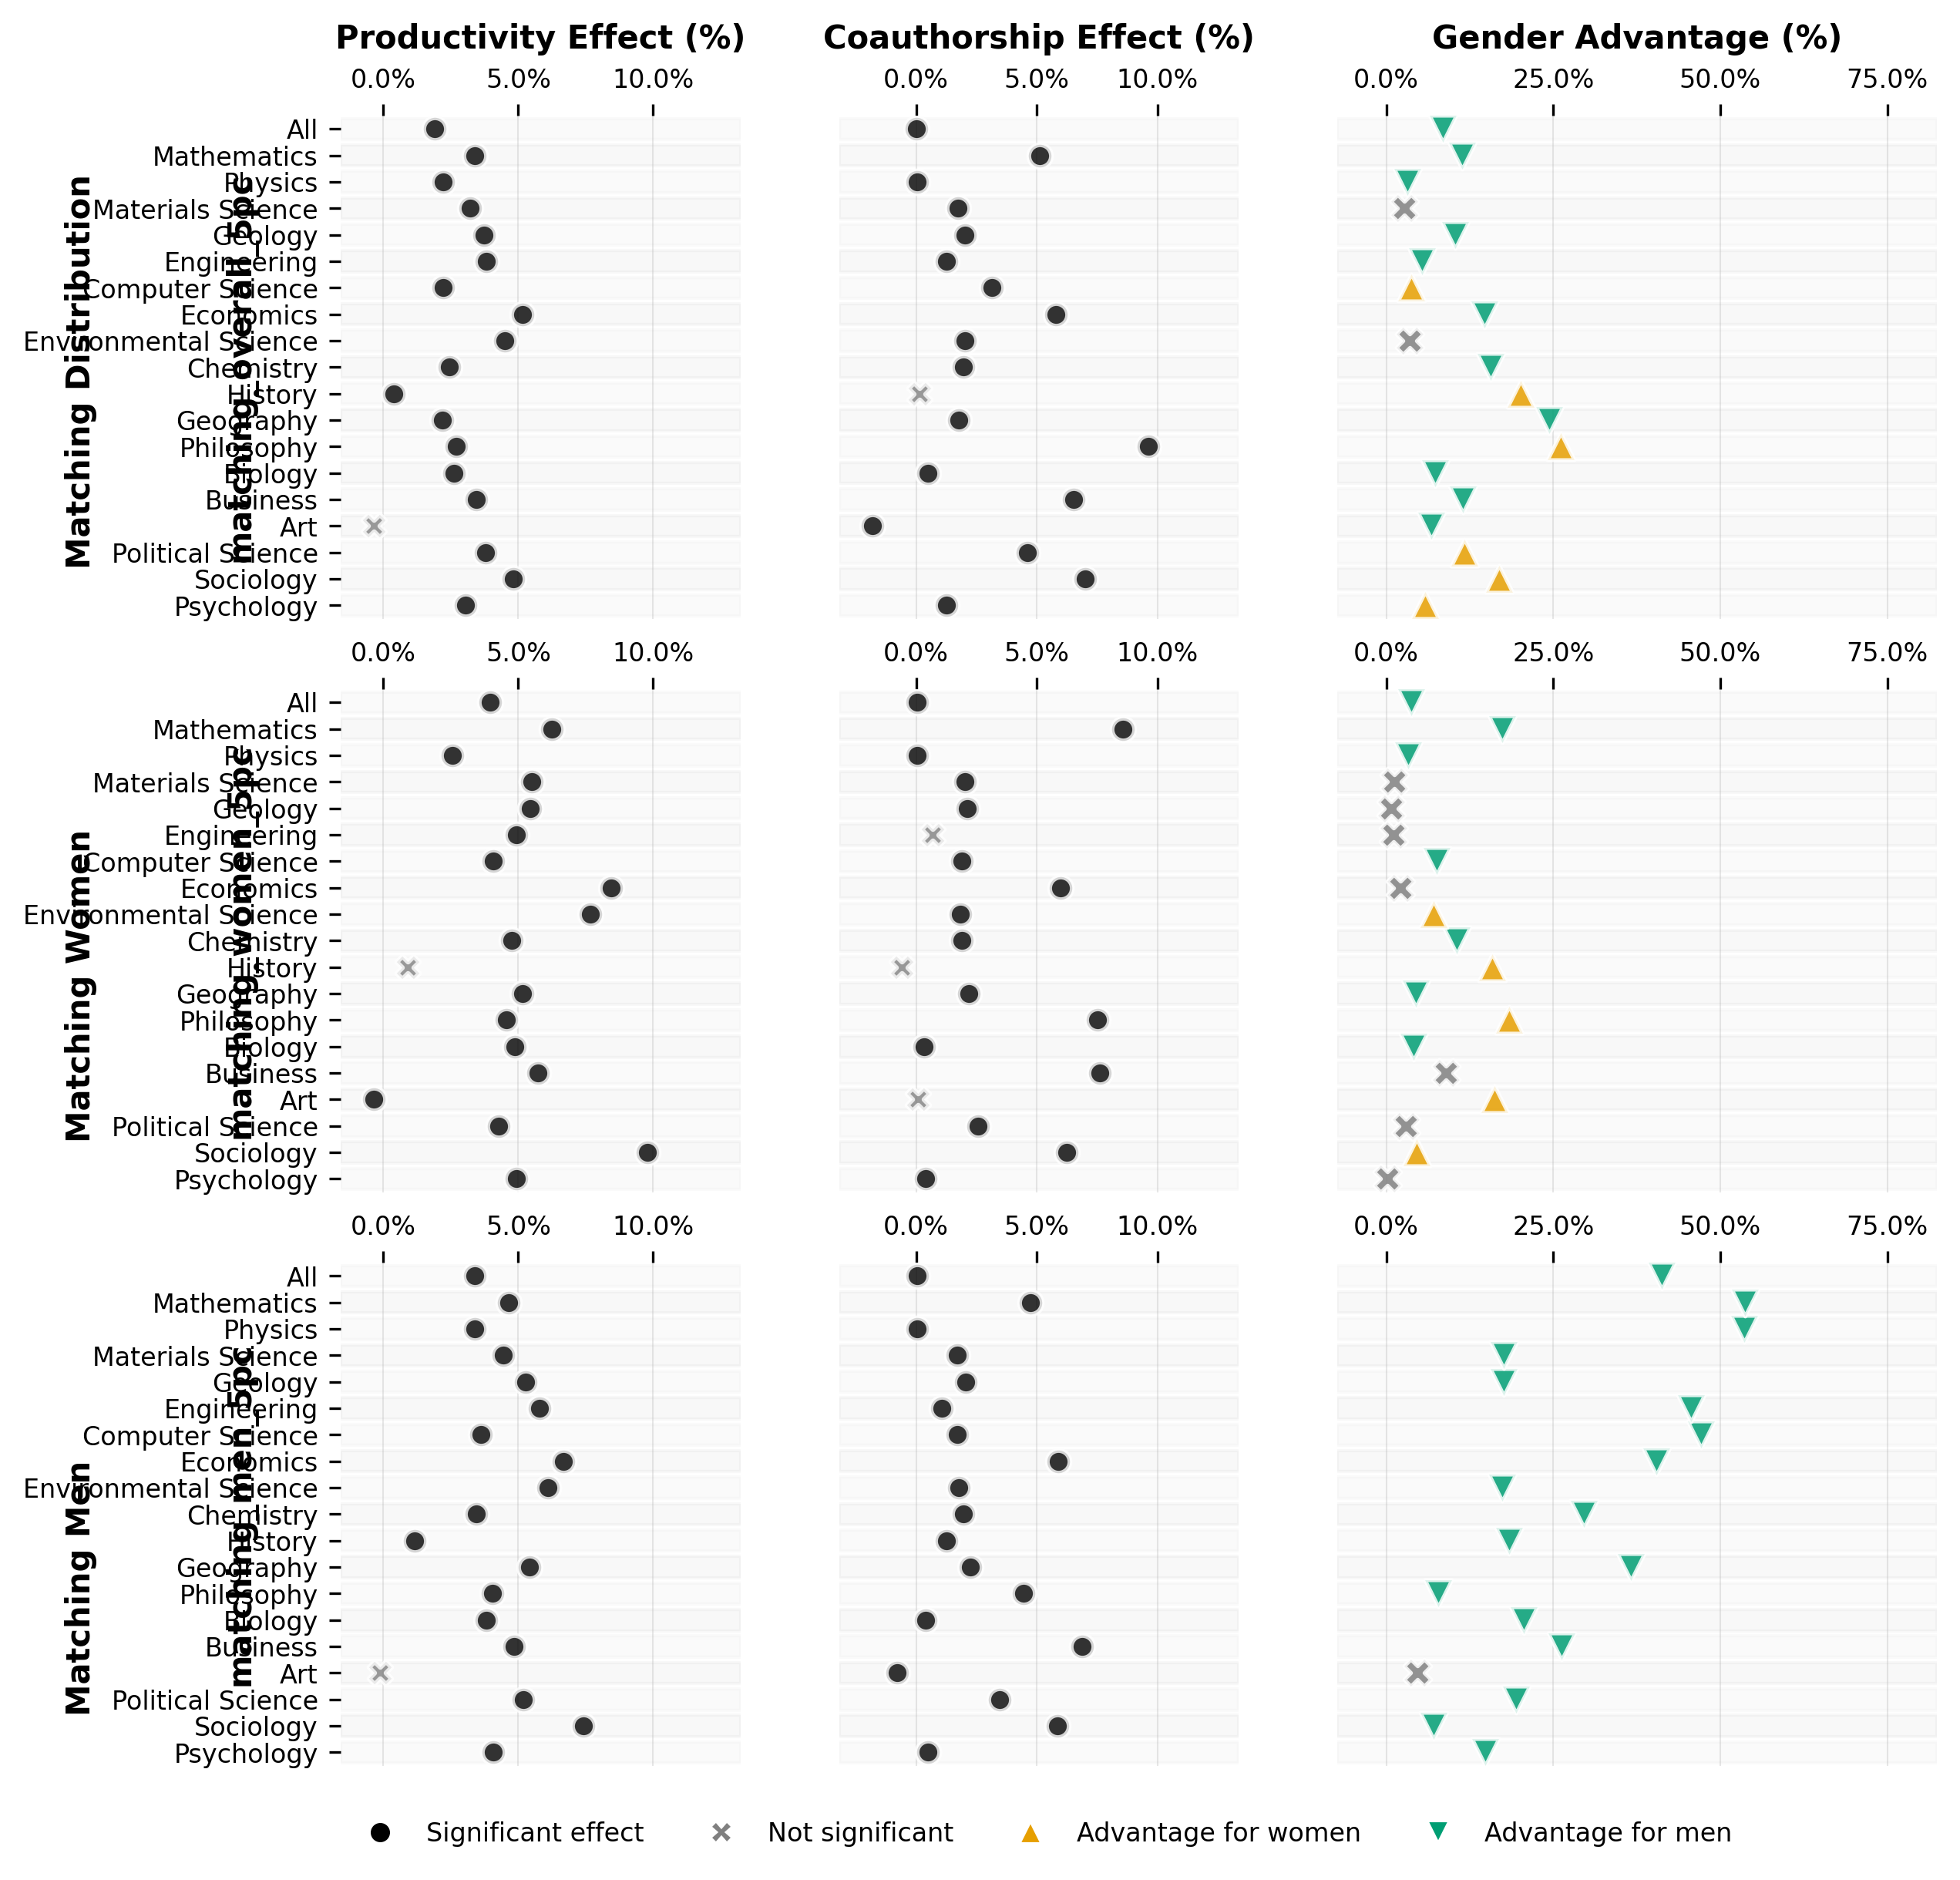

Completed analysis with 3 rows for different researcher types


In [21]:
# Set up plotting parameters
plt.rcParams['text.usetex'] = False  # Set to True if you have LaTeX installed
plt.rcParams['font.size'] = 9

# Define colors matching your original style
colors = {
    'All': 'grey',
    'male': '#009E73',
    'female': '#E69F00'
}

# Variables that we want to include in the figure
key_metrics = ['Productivity', 'Collaborations', 'Gender']

markers = {"female": "P", "male": "X"}

# Parameters 
modeltype = 'NegBinomial(citations)'
firstyear = 1990
lastyear = 2020

# Create figure with R rows and C columns 
fig = plt.figure(figsize=(8, 9), dpi=300)
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1.5])  # Last column wider for gender coefficients
ax = []
for row in range(3):
    ax_row = []
    for col in range(3):
        ax_row.append(fig.add_subplot(gs[row, col]))
    ax.append(ax_row)

# Use this variable to feed the figure
all_plot_data = []

ranking_ = '5%'
ts_values = ['matching_overall_5pc', 'matching_women_5pc', 'matching_men_5pc'] 

# ranking_ = '10%'
# ts_values = ['matching_overall_10pc', 'matching_women_10pc', 'matching_men_10pc'] 

# Markers to use
field_markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']

for ts in ts_values:
    
    print(f"\nProcessing {ts} researchers...")
    
    # Get sample
    filtered_data = compare_value[(compare_value['Ranking'] == ranking_) & (compare_value['Top Size'] == ts)]
    
    # Remove any matching style duplicates
    filtered_data = filtered_data.drop_duplicates(subset=['Field'])
    
    print(f"Final dataset has {len(filtered_data)} rows covering {len(filtered_data['Field'].unique())} unique fields")

    # Add ordering for consistent field display
    compare_value['ordered'] = compare_value['Field'].apply(lambda x: ordered_plots.index(x) if x in ordered_plots else 999)

    # Sort data by field order and add ts identifier
    plot_data = filtered_data.sort_values(by=['ordered'], ascending=False).copy()
    plot_data['ts_group'] = ts  # Add identifier for this ts group
    all_plot_data.append(plot_data)
    
# Combine all data
combined_plot_data = pd.concat(all_plot_data, ignore_index=True)

# Get unique fields in the correct order for shading (from combined data)
unique_fields = combined_plot_data['Field'].unique()
field_to_position = {field: i for i, field in enumerate(unique_fields)}

# Convert field names to numeric positions for consistent ordering
combined_plot_data['field_position'] = combined_plot_data['Field'].map(field_to_position)

# Add alternating background shading across all panels
for row in range(3):
    for col in range(3):
        for j, field in enumerate(unique_fields):
            if j % 2 == 0:  # Every other field gets light gray shading
                ax[row][col].axhspan(j - 0.4, j + 0.4, alpha=0.1, color='lightgray', zorder=0)
            else:  # Other fields get darker gray shading
                ax[row][col].axhspan(j - 0.4, j + 0.4, alpha=0.05, color='gray', zorder=0)

# Define categories
markers_config = {
    'significant': 'o',      # Circle for significant effects
    'not_significant': 'X', # X for not significant
    'female_advantage': '^', # Triangle up for female advantage  
    'male_advantage': 'v'    # Triangle down for male advantage
}

# Now plot each ts_value as a separate row
for row_idx, ts in enumerate(ts_values):
    ts_data = combined_plot_data[combined_plot_data['ts_group'] == ts]
    
    # COLUMN 1: Productivity effects
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[0]}_coef'], ts_data[f'{key_metrics[0]}_pvalue'], ts_data['field_position']):
        # Choose marker and color based on significance
        if pv < pv_limit:
            marker = markers_config['significant']
            color = "black"
        else:
            marker = markers_config['not_significant'] 
            color = "grey"
        
        # Convert to percentage effects
        prod_effect = (np.exp(coeff) - 1) * 100
        
        ax[row_idx][0].scatter(prod_effect, field_pos, 
                              c=color, s=50, marker=marker, edgecolor='white', linewidth=1.5, alpha=0.8)

    ax[row_idx][0].set_xlabel("", fontsize=9)
    if row_idx == 0:  # Only show field labels on the first row
        ax[row_idx][0].set_yticks(range(len(unique_fields)))
        ax[row_idx][0].set_yticklabels(unique_fields)
    else:
        ax[row_idx][0].set_ylabel("")
        # ax[row_idx][0].set_yticks([])

    # COLUMN 2: Collaborations effects
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[1]}_coef'], ts_data[f'{key_metrics[1]}_pvalue'], ts_data['field_position']):
        # Choose marker and color based on significance
        if pv < pv_limit:
            marker = markers_config['significant']
            color = "black"
        else:
            marker = markers_config['not_significant']
            color = "grey"
        
        # Convert to percentage effects
        collab_effect = (np.exp(coeff) - 1) * 100
        
        ax[row_idx][1].scatter(collab_effect, field_pos, 
                              c=color, s=50, marker=marker, edgecolor='white', linewidth=1.5, alpha=0.8)

    ax[row_idx][1].set_xlabel("", fontsize=9)
    ax[row_idx][1].set_yticks([])

    # COLUMN 3: Gender coefficients (always positive values)
    for coeff, pv, field_pos in zip(ts_data[f'{key_metrics[2]}_coef'], ts_data[f'{key_metrics[2]}_pvalue'], ts_data['field_position']):
        exp_coeff = np.exp(coeff)
        
        # Calculate percentage advantage (always positive) and assign marker/color
        if pv >= pv_limit:  # Not significant
            percentage = (1/exp_coeff - 1) * 100 if exp_coeff < 1 else (exp_coeff - 1) * 100
            marker = markers_config['not_significant']
            color = "grey"
        elif exp_coeff < 1:  # Female advantage (significant)
            percentage = (1/exp_coeff - 1) * 100  # Make positive
            marker = markers_config['female_advantage']
            color = colors['female']
        else:  # Male advantage (significant)
            percentage = (exp_coeff - 1) * 100    # Already positive
            marker = markers_config['male_advantage']
            color = colors['male']
        
        ax[row_idx][2].scatter(percentage, field_pos,
                              c=color, s=70, marker=marker, 
                              edgecolor='white', linewidth=1.2, alpha=0.85)

    # Add vertical reference line (removed since we don't need 0 reference for always-positive values)
    # ax[row_idx][2].axvline(0, color='lightgrey', linestyle='dotted', alpha=0.6, linewidth=1)
    ax[row_idx][2].set_xlabel("", fontsize=9)
    ax[row_idx][2].set_yticks([])

# Add row labels on the left side
row_labels = [ts_values[i] for i in range(3)]
for row_idx, label in enumerate(row_labels):
    # Add row label to the left of the first column
    ax[row_idx][0].text(-0.25, 0.5, label, transform=ax[row_idx][0].transAxes, 
                       fontsize=10, fontweight='bold', va='center', ha='center', rotation=90)

# Style all panels
for row in range(3):
    for col in range(3):
        ax[row][col].spines['right'].set_visible(False)
        ax[row][col].spines['top'].set_visible(False)
        ax[row][col].spines['bottom'].set_visible(False)
        ax[row][col].spines['left'].set_visible(False)
        
        # Move x-axis to top
        ax[row][col].xaxis.tick_top()
        ax[row][col].tick_params(labelbottom=False, labeltop=True)
        ax[row][col].xaxis.set_label_position('top')
        
        # Set y-axis to use field positions and labels
        ax[row][col].set_ylim(-0.5, len(unique_fields) - 0.5)
        if col == 0:
            ax[row][col].set_yticks(range(len(unique_fields)))
            ax[row][col].set_yticklabels(ts_data['Field'].unique())
        else:
            ax[row][col].set_yticks([])
            
        # Style ticks
        ax[row][col].tick_params(axis='x', labelsize=8)
        ax[row][col].tick_params(axis='y', labelsize=8)
        
        ax[row][col].set_ylabel("")
        
        # Add grid lines
        ax[row][col].grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
        ax[row][col].set_axisbelow(True)

# Add column headers only on the top row
column_headers = ['Productivity Effect (%)', 'Coauthorship Effect (%)', 'Gender Advantage (%)']
for col_idx, header in enumerate(column_headers):
    ax[0][col_idx].text(0.5, 1.12, header, transform=ax[0][col_idx].transAxes, 
                       fontsize=10, fontweight='bold', va='bottom', ha='center')


column_headers = ['Matching Distribution', 'Matching Women', 'Matching Men']
for row_idx, header in enumerate(column_headers):
    ax[row_idx][0].text(-0.65, 0.1, header, transform=ax[row_idx][0].transAxes,rotation=90, 
                       fontsize=10, fontweight='bold', va='bottom', ha='center')

# Calculate global ranges for consistent scaling across all rows
all_prod_effects = []
all_collab_effects = []
all_gender_percentages = []

for ts in ts_values:
    ts_data = combined_plot_data[combined_plot_data['ts_group'] == ts]
    
    # Calculate productivity effects
    if f'{key_metrics[0]}_coef' in ts_data.columns:
        prod_effects = (ts_data[f'{key_metrics[0]}_coef'].apply(lambda x: np.exp(x)) - 1) * 100
        all_prod_effects.extend(prod_effects.tolist())
    
    # Calculate collaboration effects
    if f'{key_metrics[1]}_coef' in ts_data.columns:
        collab_effects = (ts_data[f'{key_metrics[1]}_coef'].apply(lambda x: np.exp(x)) - 1) * 100
        all_collab_effects.extend(collab_effects.tolist())
    
    # Calculate gender percentages (always positive)
    if f'{key_metrics[2]}_coef' in ts_data.columns:
        for coeff in ts_data[f'{key_metrics[2]}_coef']:
            exp_coeff = np.exp(coeff)
            if exp_coeff < 1:  # Female advantage
                percentage = (1/exp_coeff - 1) * 100  # Make positive
            else:  # Male advantage  
                percentage = (exp_coeff - 1) * 100
            all_gender_percentages.append(percentage)

# Calculate global ranges with margins
prod_min, prod_max = min(all_prod_effects), max(all_prod_effects)
prod_max = 12
prod_range = prod_max - prod_min
prod_margin = prod_range * 0.1
global_prod_xlim = (prod_min - prod_margin, prod_max + prod_margin)

collab_min, collab_max = min(all_collab_effects), max(all_collab_effects)
collab_max = 12
collab_range = collab_max - collab_min
collab_margin = collab_range * 0.1
global_collab_xlim = (collab_min - collab_margin, collab_max + collab_margin)

gender_min, gender_max = min(all_gender_percentages), max(all_gender_percentages)
gender_max = 75
gender_range = gender_max - gender_min
gender_margin = gender_range * 0.1
global_gender_xlim = (gender_min - gender_margin, gender_max + gender_margin)

# Apply global ranges to all panels
for row in range(3):
    # Column 1: Productivity effects - same range for all rows
    ax[row][0].set_xlim(global_prod_xlim)
    ax[row][0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][0].locator_params(axis='x', nbins=4)
    
    # Column 2: Collaboration effects - same range for all rows
    ax[row][1].set_xlim(global_collab_xlim)
    ax[row][1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][1].locator_params(axis='x', nbins=4)
    
    # Column 3: Gender advantages - same range for all rows, always positive
    ax[row][2].set_xlim(global_gender_xlim)
    ax[row][2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax[row][2].locator_params(axis='x', nbins=4)

# Create simplified legend with different markers
legend_elements = [
    # Significance indicators for Productivity and Collaboration columns
    plt.Line2D([0], [0], marker=markers_config['significant'], color='w', markerfacecolor='black', 
               markersize=7, linestyle='', label="Significant effect"),
    plt.Line2D([0], [0], marker=markers_config['not_significant'], color='w', markerfacecolor='grey', 
               markersize=7, linestyle='', label="Not significant"),
    
    # Gender advantage indicators (for gender column only)
    plt.Line2D([0], [0], marker=markers_config['female_advantage'], color='w', markerfacecolor=colors['female'], 
               markersize=7, linestyle='', label="Advantage for women"),
    plt.Line2D([0], [0], marker=markers_config['male_advantage'], color='w', markerfacecolor=colors['male'], 
               markersize=7, linestyle='', label="Advantage for men")
]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.10), frameon=False,
           ncol=4, fontsize=8)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, left=0.12)  # Extra space for row labels and legend

# Save the figure
plt.savefig(f"three_row_research_metrics_by_ts_5pct.svg", dpi=300, bbox_inches='tight')
plt.savefig(f"three_row_research_metrics_by_ts_5pct.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Completed analysis with {len(ts_values)} rows for different researcher types")